# Inversão não-linear de dados de grav para estimar o relevo de uma bacia sedimentar

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import harmonica as hm
import bordado as bd

## Gerar dados sintéticos

In [2]:
def gaussiana(x, amplitude, deslocamento, desvio_padrão):
    return amplitude * np.exp(-((x - deslocamento) / desvio_padrão)**2)

def sintético():
    n_prismas = 100
    xmin, xmax = 10e3, 90e3
    x = bd.line_coordinates(xmin, xmax, size=n_prismas, pixel_register=True)
    profundidades = (
        gaussiana(x, amplitude=5e3, deslocamento=40e3, desvio_padrão=20e3)
        + gaussiana(x, amplitude=2e3, deslocamento=75e3, desvio_padrão=10e3)
        + gaussiana(x, amplitude=-2e3, deslocamento=35e3, desvio_padrão=10e3)
    )
    profundidades -= profundidades.min()
    return profundidades, xmin, xmax

def plota_prismas(profundidades, xmin, xmax, ax=None, figsize=(9, 3)):
    bordas = bd.line_coordinates(
        xmin, xmax, size=profundidades.size + 1,
    )
    x = [xmin]
    y = [0]
    for i in range(profundidades.size):
        x.extend([bordas[i], bordas[i + 1]])
        y.extend([profundidades[i], profundidades[i]])
    x.append(xmax)
    y.append(0)
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        ax.set_xlabel("x [m]")
        ax.set_ylabel("profundidade [m]")
    ax.set_ylim(np.max(profundidades) * 1.05, 0)
    ax.plot(x, y)
    return ax
    

<Axes: xlabel='x [m]', ylabel='profundidade [m]'>

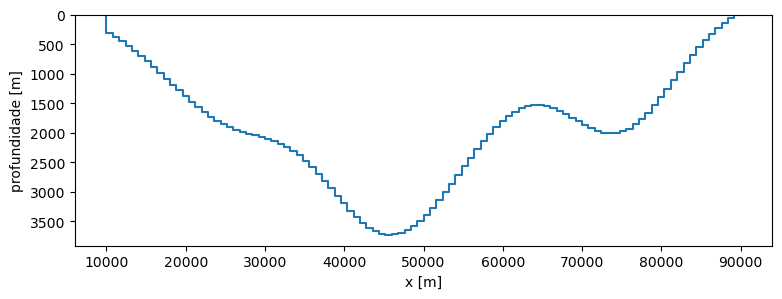

In [3]:
profundidades, xmin, xmax = sintético()
plota_prismas(profundidades, xmin, xmax) 

In [4]:
def modelagem_direta(profundidades, xmin, xmax, x, contraste_densidade):    
    coordenadas = (x, np.zeros_like(x), np.zeros_like(x))
    bordas = bd.line_coordinates(xmin, xmax, size=profundidades.size + 1)
    prismas = []
    for i in range(profundidades.size):
        if profundidades[i] >= 0:
            base = -profundidades[i]
            topo = 0
        else:
            topo = -profundidades[i]
            base = 0
        prismas.append([bordas[i], bordas[i + 1], -500e3, 500e3, base, topo])
    dados = hm.prism_gravity(
        coordenadas, prismas, np.full_like(profundidades, contraste_densidade), field="g_z",
    )
    return dados

In [5]:
x = bd.line_coordinates(0, 100e3, size=100)
contraste_densidade = -200  # kg/m³
dados = modelagem_direta(profundidades, xmin, xmax, x, contraste_densidade)

<Axes: >

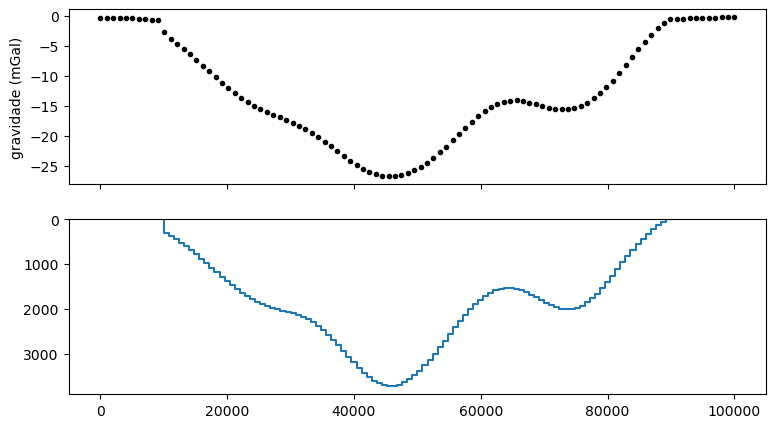

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(9, 5), sharex=True)
ax = axes[0]
ax.plot(x, dados, ".k")
ax.set_ylabel("gravidade (mGal)")
plota_prismas(profundidades, xmin, xmax, ax=axes[1])

## Inversão com método de Newton

In [7]:
def jacobiana(x, p, xmin, xmax, contraste_densidade, deltaz=10):
    M = p.size
    N = x.size  
    bordas = bd.line_coordinates(xmin, xmax, size=M + 1)
    coordenadas = (x, np.zeros_like(x), np.zeros_like(x))
    jacobiana = np.empty((N, M))
    for j in range(M):
        if p[j] + deltaz >= 0:
            base = -(p[j] + deltaz)
            topo = 0
        else:
            topo = -(p[j] + deltaz)
            base = 0
        prisma_j_mais = [[bordas[j], bordas[j + 1], -500e3, 500e3, base, topo]]
        if p[j] - deltaz >= 0:
            base = -(p[j] - deltaz)
            topo = 0
        else:
            topo = -(p[j] - deltaz)
            base = 0
        prisma_j_menos = [[bordas[j], bordas[j + 1], -500e3, 500e3, base, topo]]
        g_mais = hm.prism_gravity(coordenadas, prisma_j_mais, contraste_densidade, field="g_z")
        g_menos = hm.prism_gravity(coordenadas, prisma_j_menos, contraste_densidade, field="g_z")
        jacobiana[:, j] = (g_mais - g_menos) / (2 * deltaz)
    return jacobiana

In [8]:
def inversão_newton(p, x, dados, xmin, xmax, contraste_densidade, max_iterações=50, tolerância=0.01):    
    M = p.size
    residuo = dados - modelagem_direta(p, xmin, xmax, x, contraste_densidade)
    função_objetivo = [np.linalg.norm(residuo)**2]
    for iteração in range(max_iterações):
        A = jacobiana(x, p, xmin, xmax, contraste_densidade)
        deltap = np.linalg.solve(A.T @ A, A.T @ residuo)
        p = p + deltap
        residuo = dados - modelagem_direta(p, xmin, xmax, x, contraste_densidade)
        função_objetivo.append(np.linalg.norm(residuo)**2)
        if (função_objetivo[-1] - função_objetivo[-2]) / função_objetivo[-2] < tolerância:
            break
    return p, função_objetivo

<Axes: >

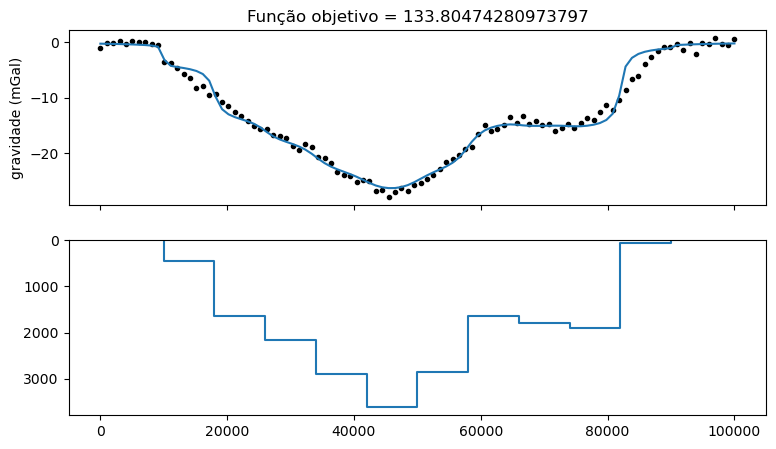

In [9]:
M = 10
p_inicial = np.full(M, 2000)
dados_ruido = dados + np.random.default_rng().normal(0, 0.5, dados.size)
p_newton, objetivo_newton = inversão_newton(p_inicial, x, dados_ruido, xmin, xmax, contraste_densidade)
dados_preditos = modelagem_direta(p_newton, xmin, xmax, x, contraste_densidade)


fig, axes = plt.subplots(2, 1, figsize=(9, 5), sharex=True)
ax = axes[0]
ax.set_title(f"Função objetivo = {objetivo_newton[-1]}")
ax.plot(x, dados_ruido, ".k")
ax.plot(x, dados_preditos, "-")
ax.set_ylabel("gravidade (mGal)")
#plota_prismas(profundidades, xmin, xmax, ax=axes[1])
plota_prismas(p_newton, xmin, xmax, ax=axes[1])

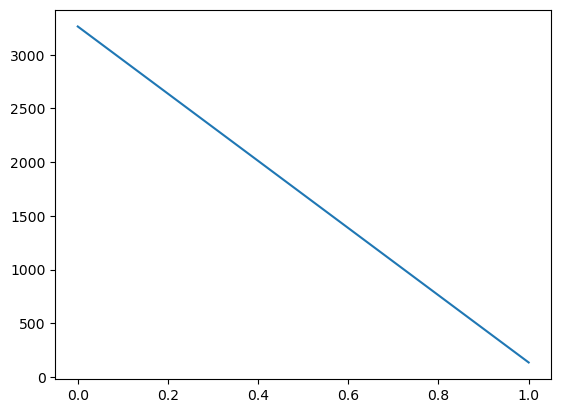

In [10]:
plt.plot(objetivo_newton)

## Inversão com Levemberg-Marquardt

In [11]:
def inversão_levmarq(
    p, x, dados, xmin, xmax, contraste_densidade, 
    alpha=1, dalpha=10, max_iterações=50, tolerância=0.01,
):    
    M = p.size
    residuo = dados - modelagem_direta(p, xmin, xmax, x, contraste_densidade)
    função_objetivo = [np.linalg.norm(residuo)**2]
    I = np.identity(p.size)
    for iteração in range(max_iterações):
        A = jacobiana(x, p, xmin, xmax, contraste_densidade)
        H = A.T @ A
        # Pre-condicionador de Jacobi
        diagonal = np.abs(np.diagonal(H))
        P = np.diag(1 / diagonal)
        H = P @ H    
        gradiente = P @ A.T @ residuo
        for m in range(50):
            deltap = np.linalg.solve(H + alpha * I, gradiente)
            residuo = dados - modelagem_direta(p + deltap, xmin, xmax, x, contraste_densidade)        
            if np.linalg.norm(residuo)**2 > função_objetivo[-1]:
                alpha = alpha * dalpha
            else:
                alpha = alpha / dalpha
                break
        p = p + deltap
        residuo = dados - modelagem_direta(p, xmin, xmax, x, contraste_densidade)
        função_objetivo.append(np.linalg.norm(residuo)**2)
        if (função_objetivo[-1] - função_objetivo[-2]) / função_objetivo[-2] < tolerância:
            break
    return p, função_objetivo

<Axes: >

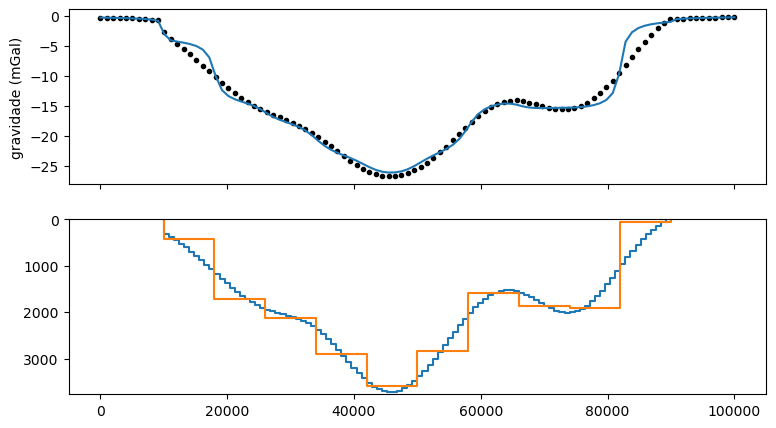

In [12]:
M = 10
p_inicial = np.full(M, 2000)
p_newton, objetivo_levmarq = inversão_levmarq(
    p_inicial, x, dados, xmin, xmax, contraste_densidade, alpha=1e-6, dalpha=2,
)
dados_preditos = modelagem_direta(p_newton, xmin, xmax, x, contraste_densidade)

fig, axes = plt.subplots(2, 1, figsize=(9, 5), sharex=True)
ax = axes[0]
ax.plot(x, dados, ".k")
ax.plot(x, dados_preditos, "-")
ax.set_ylabel("gravidade (mGal)")
plota_prismas(profundidades, xmin, xmax, ax=axes[1])
plota_prismas(p_newton, xmin, xmax, ax=axes[1])